In [1]:
%cd ../..

C:\Users\Wight\PycharmProjects\ThesisMain


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict


from PIL import Image
import os
from models.CSRNet.CSRNet import CSRNet
from models.CSRNet.CSRNet_functional import CSRNet_functional

import importlib
import time

# Settings and Parameters
Here we define the DeiT model that we wish to evaluate and the corresponding parameters to evaluate it.

In [3]:
# trained_model_path = 'notebooks\\TL\\save_state_ep_560_new_best_MAE_7.454.pth'  # The path to trained model file (something like XYZ.pth)
trained_model_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\trained_models\\CSRNet ML WE Oneshot\\save_state_ep_2725_new_best_MAE_4.841.pth'  # The path to trained model file (something like XYZ.pth)

label_factor = 100  # The label factor used to train this specific model.
dataset = 'WE_CSRNet_Meta'  # Must be the exact name of the dataset
save_results = True  # When true, save the images, GTs and predictions. A folder for this is created automatically.
set_to_eval = 'test'  # val', 'test'. Which split to test the model on. 'train' does not work!

all_adapt_imgs = [
    [
        ['104207_1-04-S20100821071000000E20100821120000000_007550.jpg'], 
        ['200608_C08-02-S20100626083000000E20100626233000000_clip1_021050.jpg'], 
        ['200702_C09-01-S20100717083000000E20100717233000000_007550.jpg'],
        ['202201_1-01-S20100922060000000E20100922235959000_clip1_004550.jpg'],
        ['500717_D11-03-S20100717083000000E20100717233000000_016550.jpg']
    ],
    [
        ['104207_1-04-S20100821071000000E20100821120000000_172550.jpg'],
        ['200608_C08-02-S20100626083000000E20100626233000000_clip1_061550.jpg'],
        ['200702_C09-01-S20100717083000000E20100717233000000_141050.jpg'],
        ['202201_1-01-S20100922060000000E20100922235959000_clip1_023450.jpg'],
        ['500717_D11-03-S20100717083000000E20100717233000000_142550.jpg']
    ],
    [
        ['104207_1-04-S20100821071000000E20100821120000000_078050.jpg'],
        ['200608_C08-02-S20100626083000000E20100626233000000_clip1_159050.jpg'],
        ['200702_C09-01-S20100717083000000E20100717233000000_091550.jpg'],
        ['202201_1-01-S20100922060000000E20100922235959000_clip1_064850.jpg'],
        ['500717_D11-03-S20100717083000000E20100717233000000_144050.jpg']
    ]
]

# Prepare for evaluation
Use the settings to load the DeiT model and dataloader for the test set. Also loads the transform with which we can restore the original images. Cuda is required!
If save_results is True, also create the directory in which the predictions are saved.

In [4]:
loss_fn = torch.nn.MSELoss()

In [5]:
def get_dataloaders(adapt_imgs=None):
    dataloader = importlib.import_module(f'datasets.meta.{dataset}.loading_data').loading_data
    cfg_data = importlib.import_module(f'datasets.meta.{dataset}.settings').cfg_data

    train_loaders, val_loaders, test_loaders, restore_transform = dataloader(adapt_imgs)
    if set_to_eval == 'val':
        my_dataloaders = val_loaders
    elif set_to_eval == 'test':
        my_dataloaders = test_loaders
    else:
        print(f'Error: invalid set --> {set_to_eval}')
    return my_dataloaders, restore_transform, cfg_data

In [6]:
def load_model_and_optim():
    model = CSRNet()
#     model.make_alpha(42)  # Whatever, will be overwritten anyway
    model.cuda()
    state_dict = torch.load(trained_model_path)
    model.make_alpha(42)  # Whatever, will be overwritten anyway
    net = state_dict['net']
    model.load_state_dict(net)

#     model.make_alpha(42)  # Whatever, will be overwritten anyway
    model.cuda()
    
    model_functional = CSRNet_functional()
    model.eval()
        
    return model, model_functional

In [7]:
save_dir = None
if save_results:
    save_folder = 'CSRNet_meta' + '_' + dataset + '_' + set_to_eval + '_' + time.strftime("%m-%d_%H-%M", time.localtime())
    save_dir = os.path.join('notebooks', 'Meta-learning', save_folder)  # Manually change here is you want to save somewhere else
    os.mkdir(save_dir)

# Evaluation loop and save funtion

In [8]:
def eval_on_scene(model_funct, model_weights, scene_dataloader):
    model.eval()
    with torch.no_grad():
        preds = []
        gts = []
        AEs = []  # Absolute Errors
        SEs = []  # Squared Errors

        for idx, (img, gt) in enumerate(scene_dataloader):
            img = img.cuda()
           
            den = model_functional.forward(img, model_weights, training=False)  # Precicted density crops
            den = den.cpu()

            gt = gt.squeeze()  # Remove channel dim
            den = den.squeeze()  # Remove channel dim
            
#             img = restore_transform(img.squeeze())  # Original image
            pred_cnt = den.sum() / cfg_data.LABEL_FACTOR
            gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR
            
            preds.append(pred_cnt.item())
            gts.append(gt_cnt.item())
            AEs.append(torch.abs(pred_cnt - gt_cnt).item())
            SEs.append(torch.square(pred_cnt - gt_cnt).item())
            relative_error = AEs[-1] / gt_cnt * 100
#             print(f'IMG {idx:<3} '
#                   f'Prediction: {pred_cnt:<9.3f} '
#                   f'GT: {gt_cnt:<9.3f} '
#                   f'Absolute Error: {AEs[-1]:<9.3f} '
#                   f'Relative Error: {relative_error:.1f}%')
            
#             if save_path:
#                 plot_and_save_results(save_path, img, idx, gt, den, pred_cnt, gt_cnt)
            
        MAE = np.mean(AEs)
        MSE = np.sqrt(np.mean(SEs))

    return preds, gts, MAE, MSE

In [9]:
def adapt_to_scene(model, scene_dataloader):
    model.train()
    
    theta = OrderedDict((name, param) for name, param in model.named_parameters())
    theta_values = list(theta[k] for k in theta if not k.startswith('alpha.'))
    theta_names = list(k for k in theta if not k.startswith('alpha.'))
    alpha_values = list(theta[k] for k in theta if k.startswith('alpha.'))


    adapt_img, adapt_gt = scene_dataloader.dataset.get_adapt_batch()
    adapt_img = adapt_img.cuda()
    adapt_gt = adapt_gt.squeeze().cuda()

    pred = model_functional.forward(adapt_img, theta, training=True)
    pred = pred.squeeze()

    loss = loss_fn(pred, adapt_gt)
    grads = torch.autograd.grad(loss, theta_values)

    theta_prime = OrderedDict(
        (n, w - a * g) for n, w, a, g in zip(theta_names, theta_values, alpha_values, grads)
    )
    
    return theta_prime

In [10]:
def save_scene_graph(preds_before, preds_after, gts, save_name):
    MAE_before = np.mean(np.abs(np.array(preds_before) - np.array(gts)))
    MAE_after = np.mean(np.abs(np.array(preds_after) - np.array(gts)))
    save_path = os.path.join(save_dir, save_name)
    xs = np.arange(len(gts))
    plt.figure(figsize=(20,10))
    plt.title(f'MAE before: {MAE_before:.3f}, MAE after: {MAE_after:.3f}, MAE improvement: {MAE_before - MAE_after:.3f}')
    plt.plot(xs, gts, color='green', label='GT')
    plt.plot(xs, preds_before, color='blue', label='Before')
    plt.plot(xs, preds_after, '--', color='red', label='After')
    plt.legend()
#     plt.savefig(save_path)
    plt.show()

In [11]:
# model, model_functional = load_model_and_optim()  # Learning rate is not used when not adapting
# theta = OrderedDict((name, param) for name, param in model.named_parameters())

# scene_dataloaders, restore_transform, cfg_data = get_dataloaders(None)
# for idx, scene_dataloader in enumerate(scene_dataloaders):
#     print(f'scene {idx + 1}')
#     preds_before, gts, MAE_before, MSE_before = eval_on_scene(model_functional, theta, scene_dataloader)
#     print(f'  No adapt MAE: {MAE_before:.3f}, MSE: {MSE_before:.3f}')
  

Scene 1
  crowdedness=few
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 1.779/2.294
    After adapt MAE/MSE: 1.534/2.115


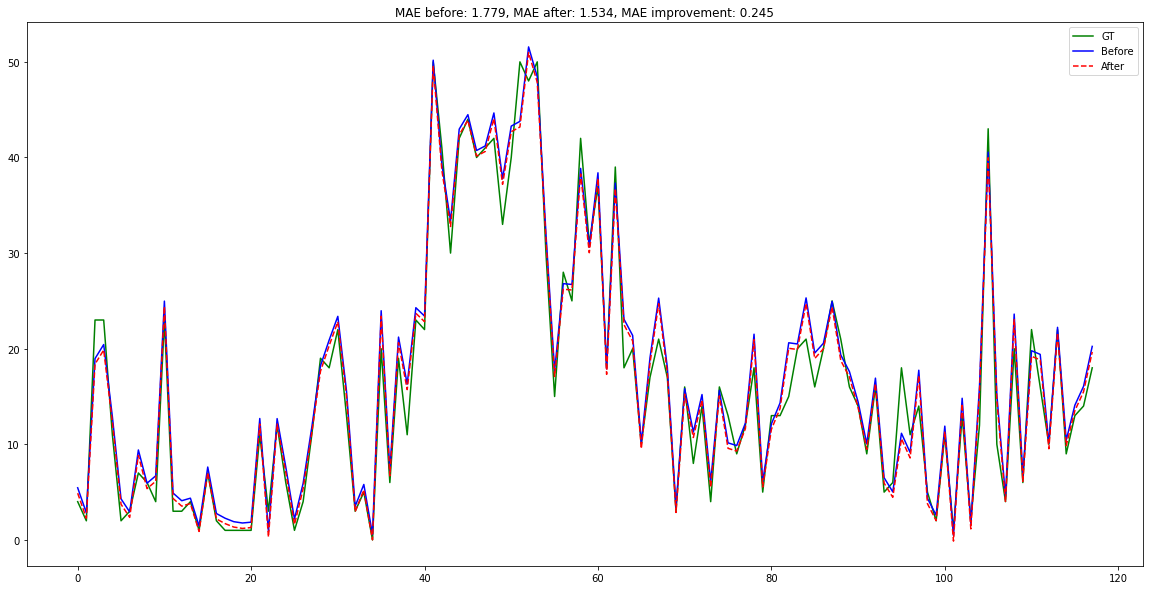

min max
0.5611470937728882
0.5922775268554688
  crowdedness=some
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 1.790/2.298
    After adapt MAE/MSE: 1.581/2.144


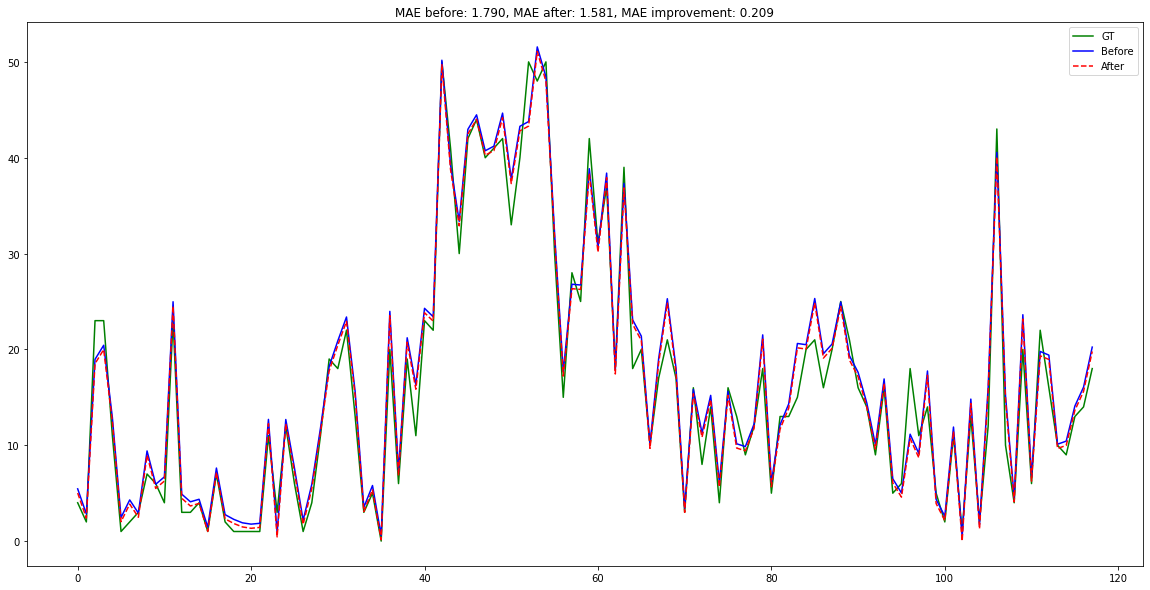

min max
0.428226113319397
0.4809913635253906
  crowdedness=many
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 1.764/2.278
    After adapt MAE/MSE: 1.754/2.326


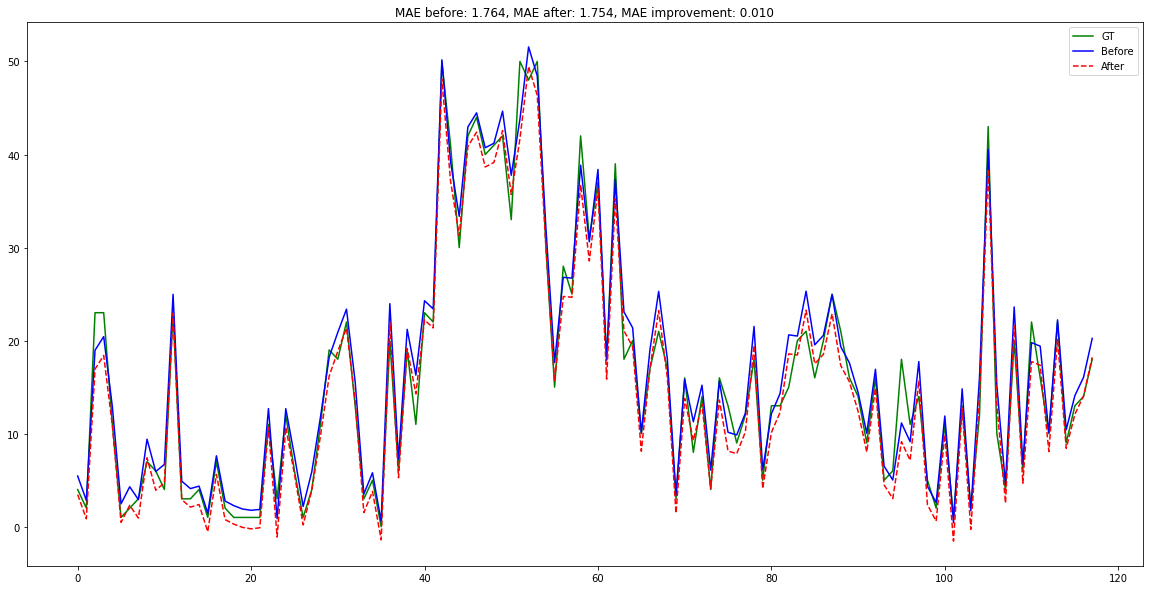

min max
1.969102293252945
2.1102638244628906
Scene 2
  crowdedness=few
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 15.918/23.592
    After adapt MAE/MSE: 15.943/23.866


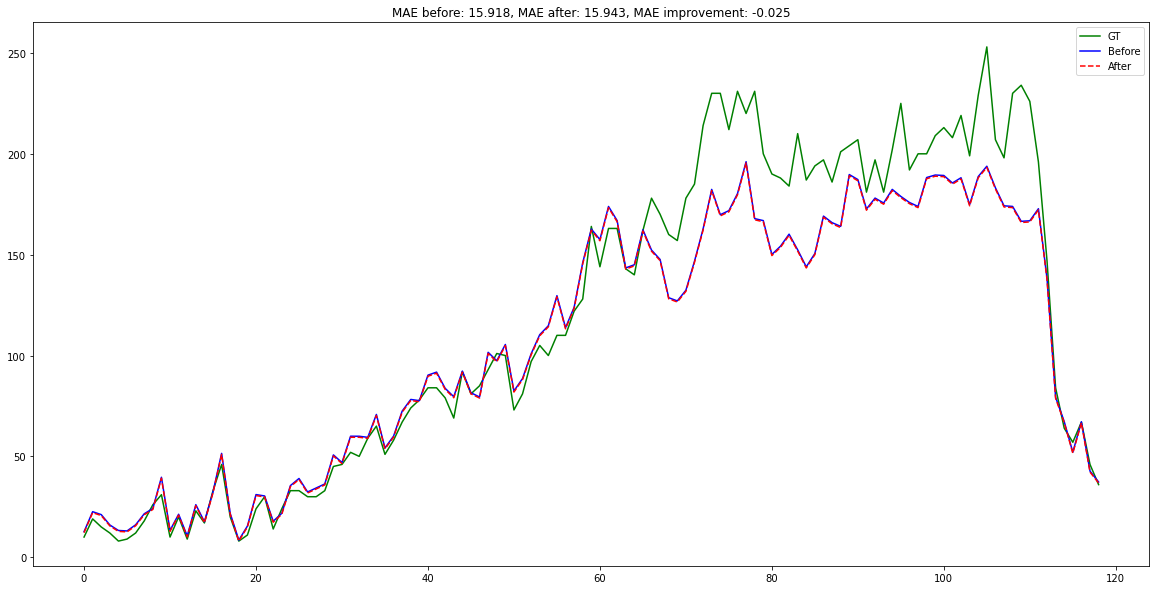

min max
0.4629631042480469
0.60009765625
  crowdedness=some
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 15.874/23.585
    After adapt MAE/MSE: 16.659/25.574


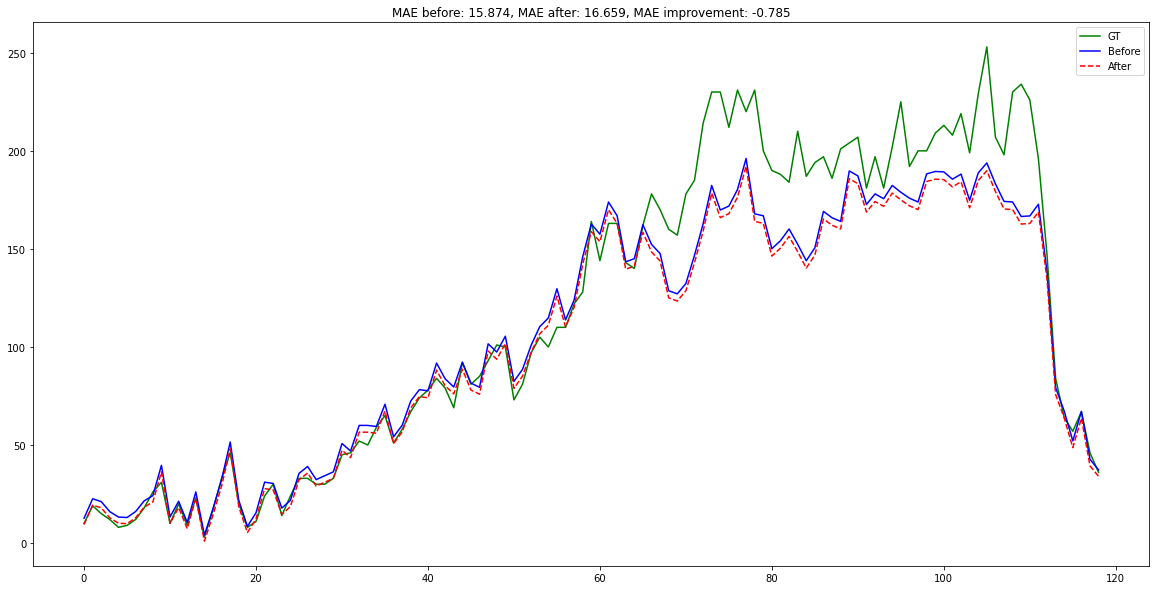

min max
3.0970128774642944
3.9720306396484375
  crowdedness=many
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 15.430/22.961
    After adapt MAE/MSE: 19.955/22.224


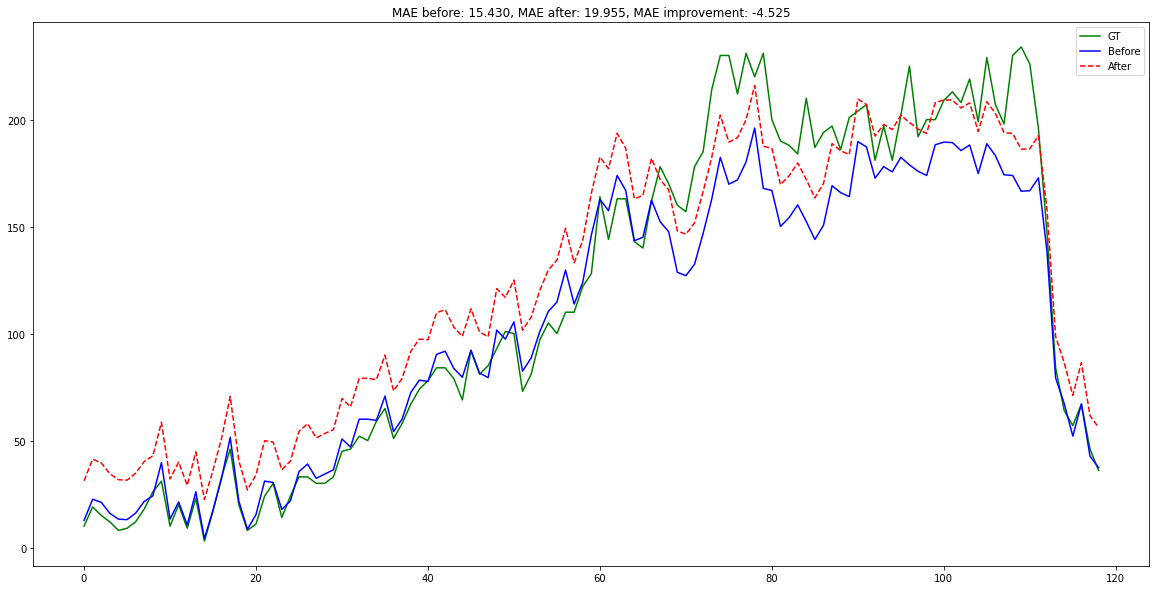

min max
-19.911056518554688
-18.357518196105957
Scene 3
  crowdedness=few
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 12.546/16.666
    After adapt MAE/MSE: 11.033/15.171


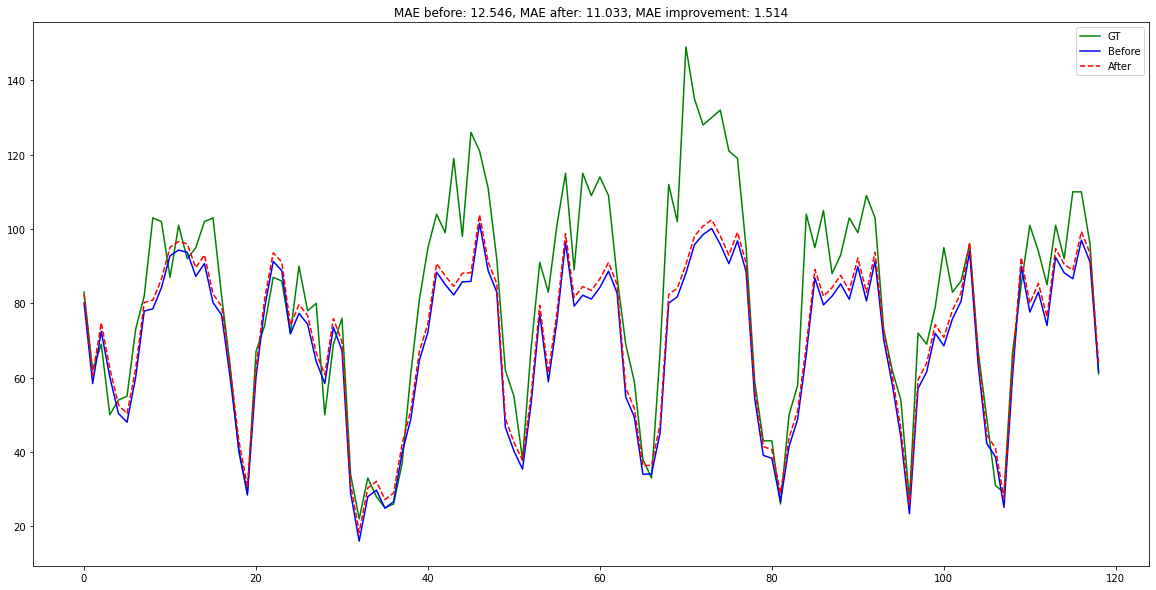

min max
-2.3632583618164062
-2.298919677734375
  crowdedness=some
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 12.606/16.688
    After adapt MAE/MSE: 12.877/16.967


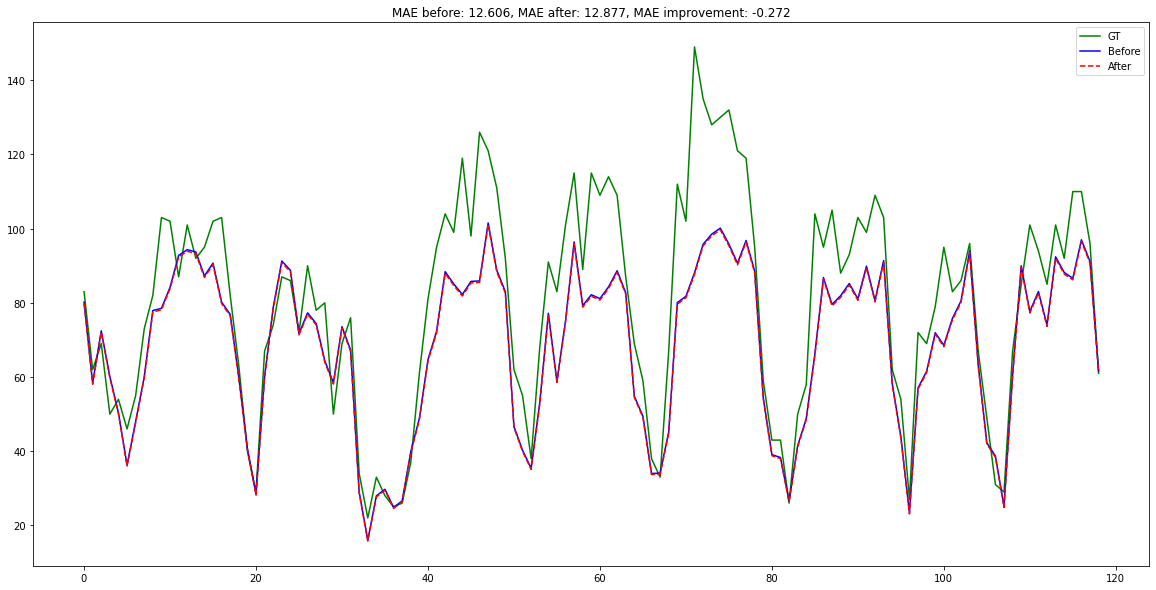

min max
0.25388050079345703
0.45537567138671875
  crowdedness=many
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 12.378/16.466
    After adapt MAE/MSE: 9.086/12.197


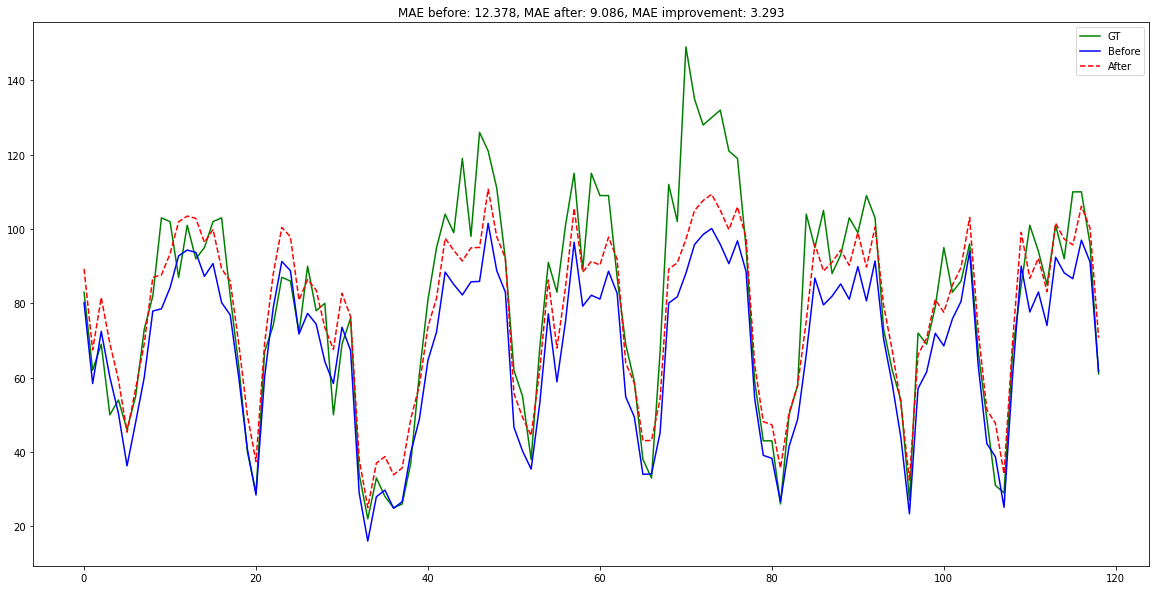

min max
-9.205299377441406
-9.003040313720703
Scene 4
  crowdedness=few
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 35.516/39.333
    After adapt MAE/MSE: 27.697/32.328


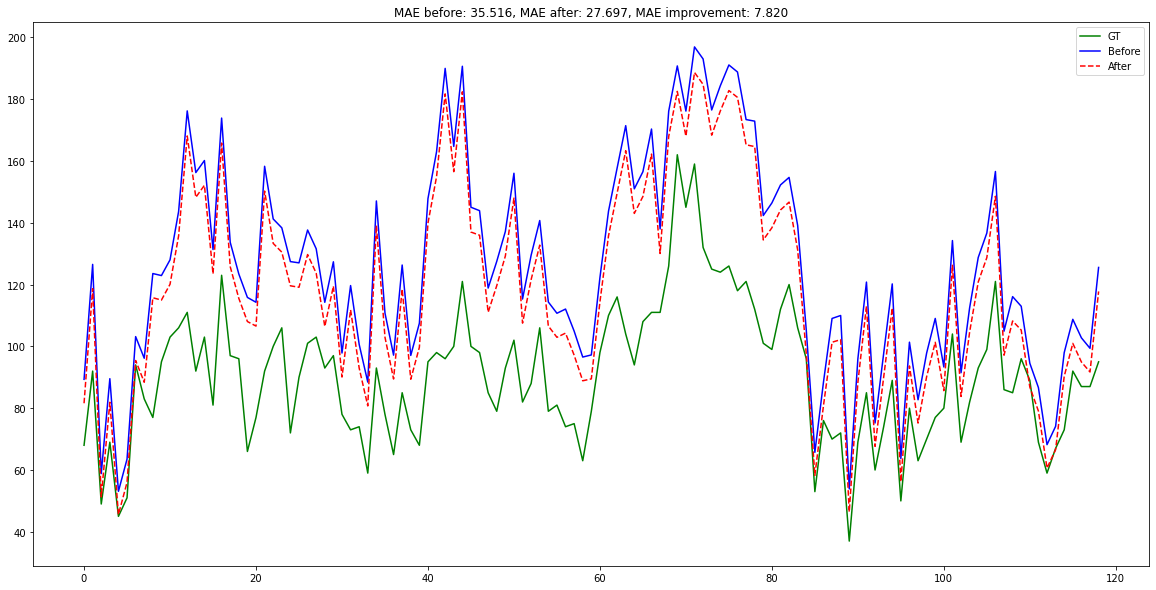

min max
7.442359924316406
8.281814575195312
  crowdedness=some
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 35.337/39.212
    After adapt MAE/MSE: 19.411/24.399


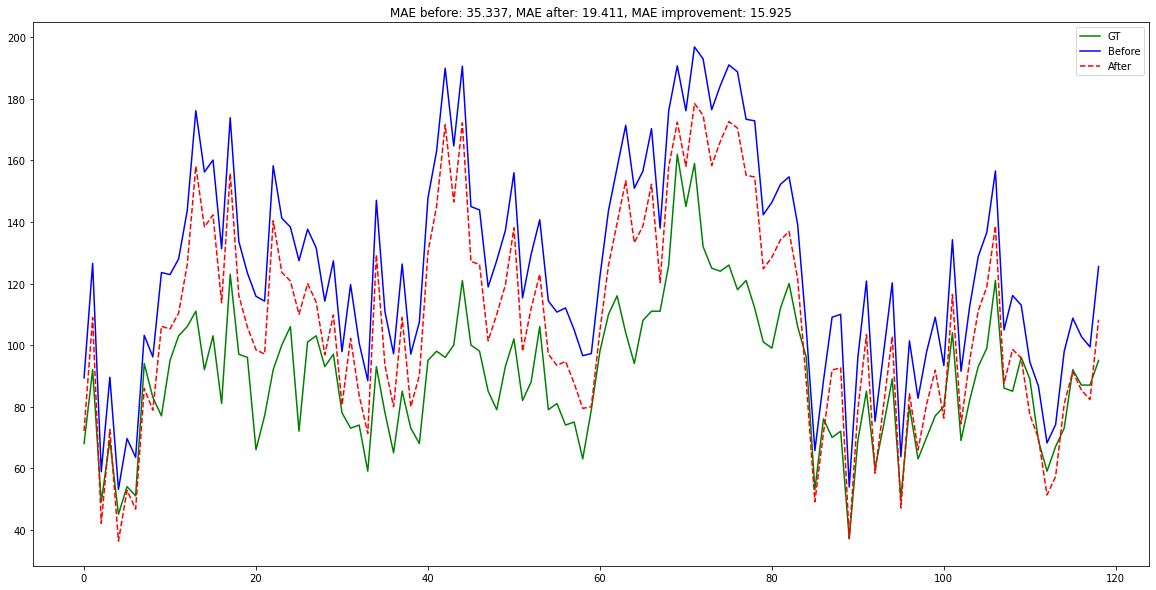

min max
16.600894927978516
18.421768188476562
  crowdedness=many
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 35.329/39.205
    After adapt MAE/MSE: 17.647/22.437


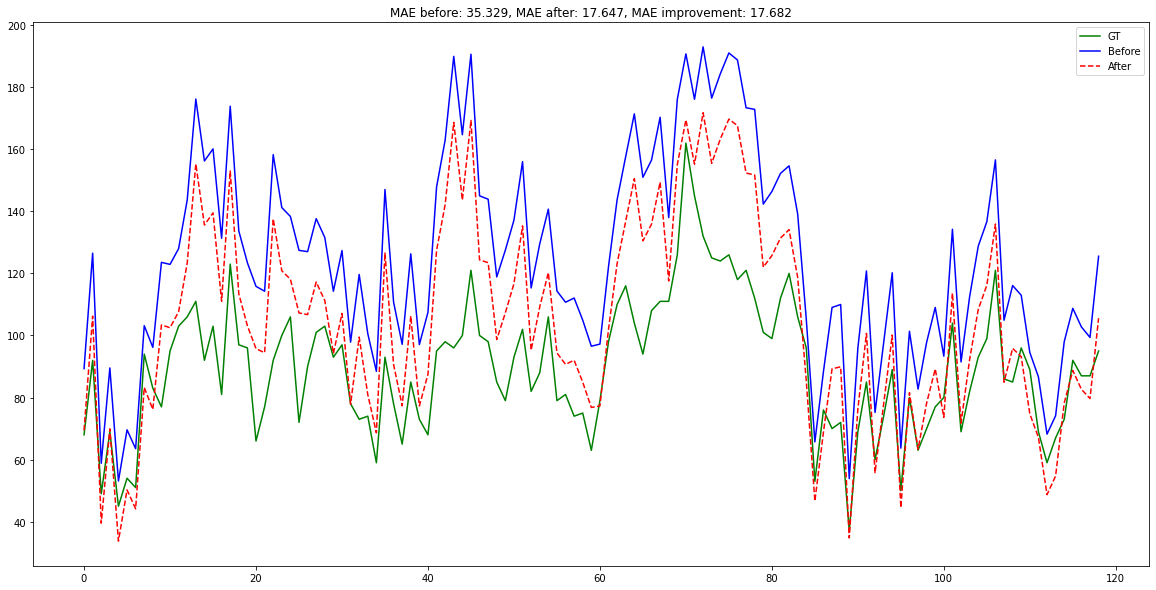

min max
19.112091064453125
21.331756591796875
Scene 5
  crowdedness=few
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 2.738/4.551
    After adapt MAE/MSE: 2.737/4.505


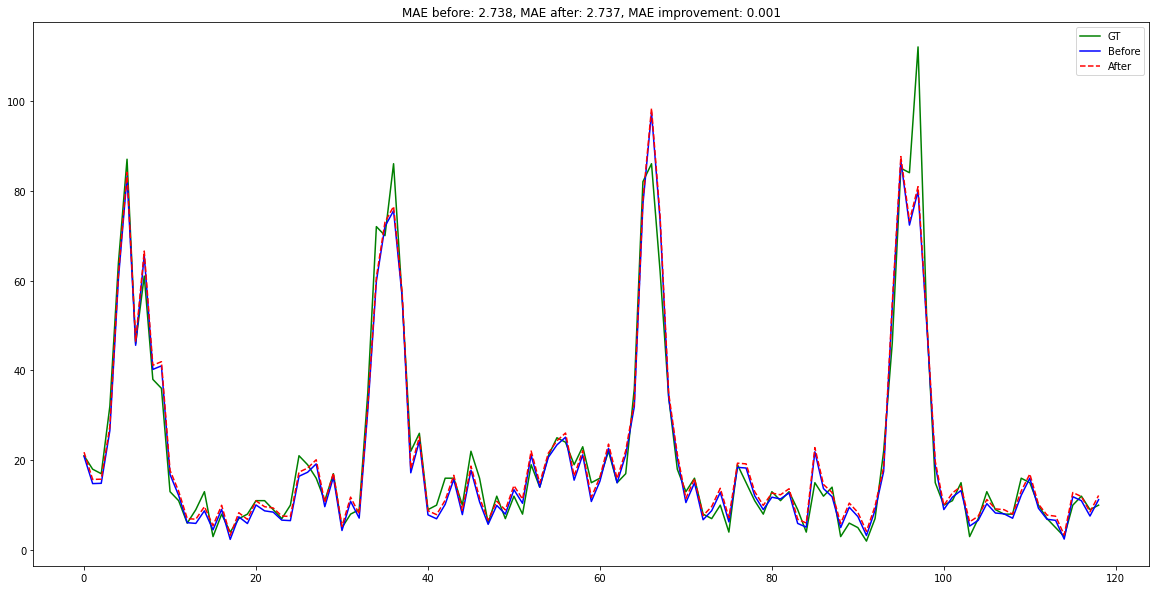

min max
-0.9444732666015625
-0.9193308353424072
  crowdedness=some
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 2.696/4.502
    After adapt MAE/MSE: 4.657/6.169


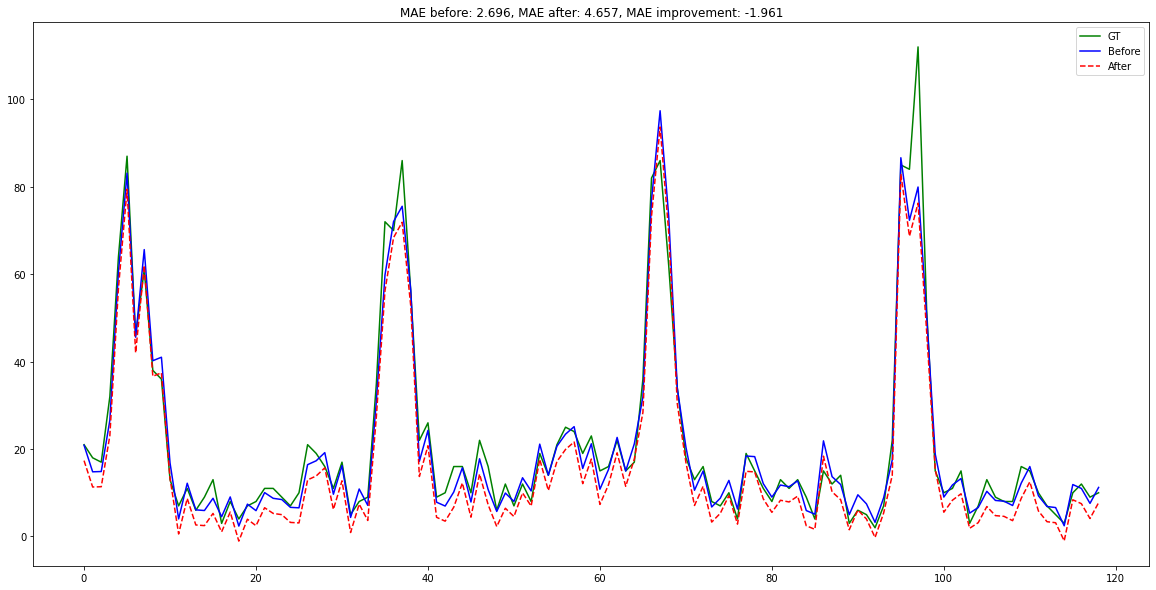

min max
3.432665467262268
3.7184906005859375
  crowdedness=many
83 train scenes found.
118 test images found.
119 test images found.
119 test images found.
119 test images found.
119 test images found.


C:\Users\Wight\Anaconda3\envs\ThesisMain\lib\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


    Before adapt MAE/MSE: 2.749/4.557
    After adapt MAE/MSE: 3.375/5.136


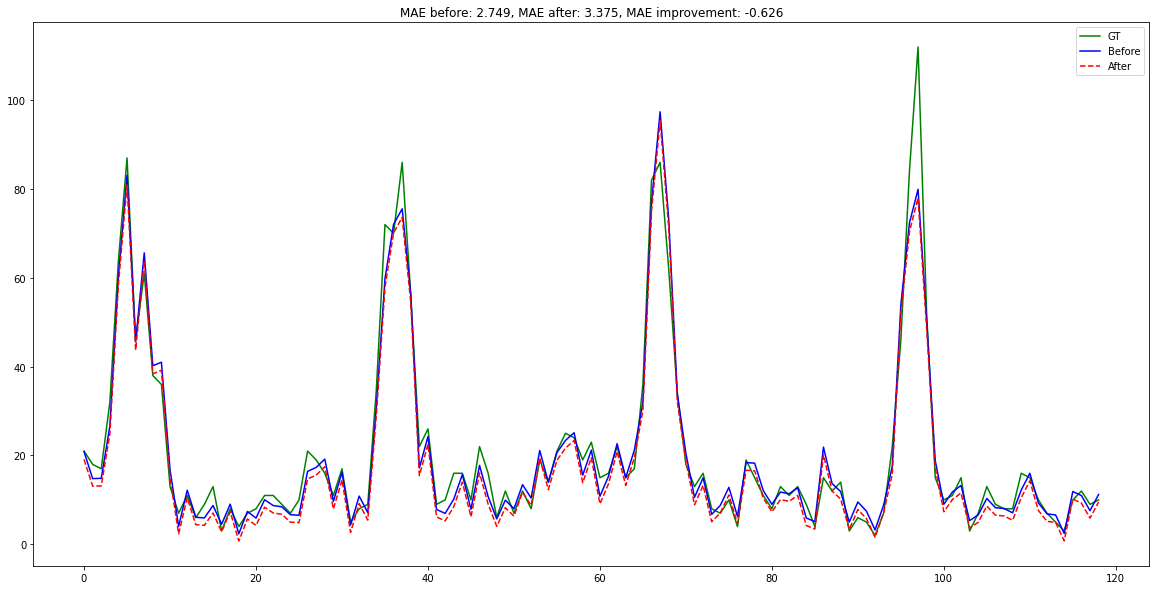

min max
1.6508859395980835
2.0108871459960938


In [12]:
crowdedness_names = ['few', 'some', 'many']

for scene_idx in range(5):
    print(f'Scene {scene_idx + 1}')
    
    for idx, adapt_imgs in enumerate(all_adapt_imgs):
        print(f'  crowdedness={crowdedness_names[idx]}')

        scene_dataloaders, restore_transform, cfg_data = get_dataloaders(adapt_imgs)
        scene_dataloader = scene_dataloaders[scene_idx]
        
        model, model_functional = load_model_and_optim()
        theta = OrderedDict((name, param) for name, param in model.named_parameters())

        preds_before, gts, MAE_before, MSE_before = eval_on_scene(model_functional, theta, scene_dataloader)
        print(f'    Before adapt MAE/MSE: {MAE_before:.3f}/{MSE_before:.3f}')
#         continue
        adapted_weights = adapt_to_scene(model, scene_dataloader)

        preds_after, gts, MAE_after, MSE_after = eval_on_scene(model_functional, adapted_weights, scene_dataloader)
        print(f'    After adapt MAE/MSE: {MAE_after:.3f}/{MSE_after:.3f}')
        
#         save_scene_graph(preds_before, preds_after, gts, f'scene_{scene_idx + 1}_img_crowdedness_{crowdedness_names[idx]}.jpg')
        
        print('min max')
        print(np.min(np.array(preds_before) - np.array(preds_after)))
        print(np.max(np.array(preds_before) - np.array(preds_after)))

In [13]:
# a = [1, 2, 4]
# b = [2, 1, 0]
# np.mean(np.abs(np.array(a) - np.array(b)))

In [14]:
# save_scene_graph(preds_before, preds_after, gts, f'scene_{scene_idx + 1}_img_crowdedness_{crowdedness_names[idx]}.jpg')

In [15]:
a = 12.3
print(f'asdasd: {a:7.3f}')

asdasd:  12.300
